# Prepare input data

**1. Connect to google drive and see if the input file is there**

In [1]:
# commentout the line below to actually run this cell!
%%script false --no-raise-error
# import google drive module and mount it
from google.colab import drive
drive.mount('/content/drive')

# list the files on the path just to check if our file is actually there
import os
path = "/content/drive/MyDrive/ML" #change your_subfolder to the actual subfolder name
for filename in os.listdir(path):
  print(filename)

**2a. Read the input file from Google Drive**

In [2]:
# commentout the line below to actually run this cell!
%%script false --no-raise-error

# Specify the correct path to your file!!
path = "/content/drive/MyDrive/ML/boiling_melting.tsv"  # Update with the correct path

table = []
a_file = open(path)
for row in a_file:
  tokens = row.split()
  table.append(tokens)

print(table[0:5])


**2a. Read the input file from GitHub**

In [12]:
import base64
import requests

input_data="https://raw.githubusercontent.com/dgront/chem-ml/refs/heads/main/INPUTS/melting_temperatures/boiling_melting.tsv"
req = requests.get(input_data)
table = []
for row in req.text.splitlines():
  tokens = row.split("\t")
  table.append(tokens)

print(table[0:5])

[['(1,1&#x27;-Biphenyl)-2,5-Diol, Diacetate', 'C16H14O4', '', '68'], ['(1,1&#x27;-Biphenyl)-4,4&#x27;-Dicarbonitrile', 'C14H8N2', '', '238'], ['(1,1&#x27;-Biphenyl)-4-Ol, 3-Amino-', 'C12H11NO', '', '198-202'], ['(1,2-Dibromoethyl)benzene', 'C8H8Br2', '133', '75'], ['(1,4-Diphenyl)-1,3-Butadiene', 'C16H14', '350', '152']]


**3. Define a function that will turn formula into input deatures**

In [4]:
import re

def parse_formula(formula: str) -> dict:
    """
    Parse a chemical formula and return a dictionary mapping each element
    to its total count.

    Args:
        formula (str): A string representing a chemical formula (e.g., "C8H6BrN").

    Returns:
        dict: A dictionary where keys are element symbols and values are their counts.
              For example, "C8H6BrN" yields {"C": 8, "H": 6, "Br": 1, "N": 1}.
    """
    # The regex matches an element symbol: one uppercase letter optionally followed by a lowercase letter,
    # and an optional count (a sequence of digits).
    pattern = r'([A-Z][a-z]?)(\d*)'
    matches = re.findall(pattern, formula)

    counts = {}
    for element, count_str in matches:
        # Default to 1 if no explicit count is provided.
        count = int(count_str) if count_str else 1
        counts[element] = counts.get(element, 0) + count

    return counts

atom_type_order = ['C', 'O', 'N', 'H', 'S', 'P', 'F', 'Cl', 'Br', 'I']

atomic_masses = {
    "H": 1.01, "Li": 6.94, "Be": 9.01, "B": 10.81, "C": 12.01, "N": 14.01, "O": 16.00, "F": 18.99, "Na": 22.99, "Mg": 24.31,
    "Al": 26.98, "Si": 28.09, "P": 30.97, "S": 32.07, "Cl": 35.45, "K": 39.10, "Ca": 40.08, "Sc": 44.96, "Ti": 47.87, "V": 50.94,
    "Cr": 52.00, "Mn": 54.94, "Fe": 55.85, "Co": 58.93, "Ni": 58.69, "Cu": 63.55, "Zn": 65.38, "Ga": 69.72, "Ge": 72.63, "As": 74.92,
    "Se": 78.97, "Br": 79.90, "Rb": 85.47, "Sr": 87.62, "Y": 88.91, "Zr": 91.22, "Nb": 92.91, "Mo": 95.95, "Tc": 98.00, "Ru": 101.07,
    "Rh": 102.91, "Pd": 106.42, "Ag": 107.87, "Cd": 112.41, "In": 114.82, "Sn": 118.71, "Sb": 121.76, "Te": 127.60, "I": 126.90,
    "Cs": 132.91, "Ba": 137.33, "Hf": 178.49, "Ta": 180.95, "W": 183.84, "Re": 186.21, "Os": 190.23, "Ir": 192.22, "Pt": 195.08,
    "Au": 196.97, "Hg": 200.59, "Tl": 204.38, "Pb": 207.20, "Bi": 208.98
}

def features_from_formula(formula: str):
  features = []
  atom_counts = parse_formula(formula)
  for atom in atom_type_order:
    features.append(atom_counts.get(atom, 0))
  mass = 0.0
  for (atom,count) in atom_counts.items():
    mass += atomic_masses[atom]*count
  features.append(mass)

  return features


 **4. Convert the input file content to actual input for training**

In [21]:
features = []   # input features
labels = []     # expected labels: table[i][2] is boiling, table[i][3] is melting temperature
for row in table[0:]:
  try:
    v = float(row[3])
    labels.append([v])
    features.append(features_from_formula(row[1]))
  except:
    pass

print(features[0:5])
print(labels[0:5])

[[16, 4, 0, 14, 0, 0, 0, 0, 0, 0, 270.3], [14, 0, 2, 8, 0, 0, 0, 0, 0, 0, 204.24], [8, 0, 0, 8, 0, 0, 0, 0, 2, 0, 263.96000000000004], [16, 0, 0, 14, 0, 0, 0, 0, 0, 0, 206.3], [10, 1, 0, 16, 0, 0, 0, 0, 0, 0, 152.26]]
[[68.0], [238.0], [75.0], [152.0], [5.0]]


**Import tensorflow libraries**

In [19]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

 **Convert from Python arrays to tensorflow tensors**

In [22]:
X = tf.convert_to_tensor(features)
Y = tf.convert_to_tensor(labels)
print(X.shape)
print(Y.shape)


(9327, 11)
(9327, 1)


# Build and train the model

**Buitd the mode i.e. the neural network**

In [33]:
N_INPUTS = len(features[0])
model = keras.Sequential([
        layers.Dense(N_INPUTS, activation='relu'),  # First hidden layer with 4 neurons
    layers.Dense(20, activation='relu'),  # Second hidden layer with 20 neurons
    layers.Dense(20, activation='relu'),  # Third hidden layer with 20 neurons
#    layers.Dense(20, activation='relu'),  # 4th hidden layer with 20 neurons (added as an example that it makes the results worse!)
    layers.Dense(1, activation='linear')  # Output layer for regression
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

**Train the model**

In [34]:
#history = model.fit(X, Y, epochs=20, batch_size=100, validation_data=(X, Y))
history = model.fit(X, Y, epochs=100, batch_size=32, validation_split=0.3)

Epoch 1/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 9789.8154 - mae: 72.5949 - val_loss: 16138.9141 - val_mae: 78.4049
Epoch 2/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9580.1475 - mae: 71.7459 - val_loss: 15584.1514 - val_mae: 75.5597
Epoch 3/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9937.4336 - mae: 69.2893 - val_loss: 15197.8848 - val_mae: 73.5046
Epoch 4/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8687.8994 - mae: 66.5108 - val_loss: 14648.7686 - val_mae: 70.8556
Epoch 5/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9410.8066 - mae: 63.5602 - val_loss: 14305.5234 - val_mae: 69.1232
Epoch 6/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7565.2500 - mae: 63.1005 - val_loss: 14184.7129 - val_mae: 67.9303
Epoch 7/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7894.1938 - mae: 61.8600 - val_loss: 14207.6738 - val_mae: 67.9289
Epoch 8/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7776.4424 - mae: 62.4288 - val_loss: 14343.

**Plot training loss**

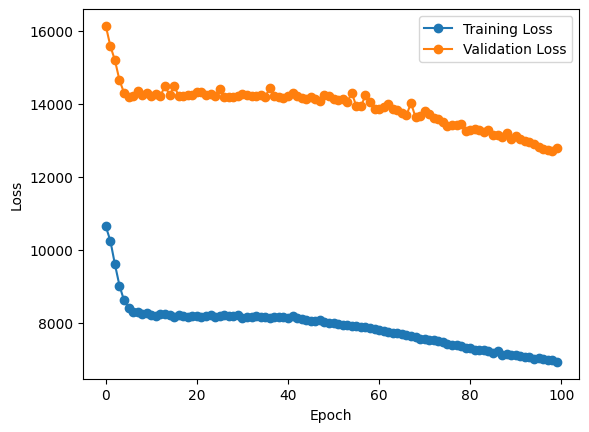

In [36]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.legend()
plt.ylabel('Loss')
plt.show()

**Print mean absolute error (MAE) during training**

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


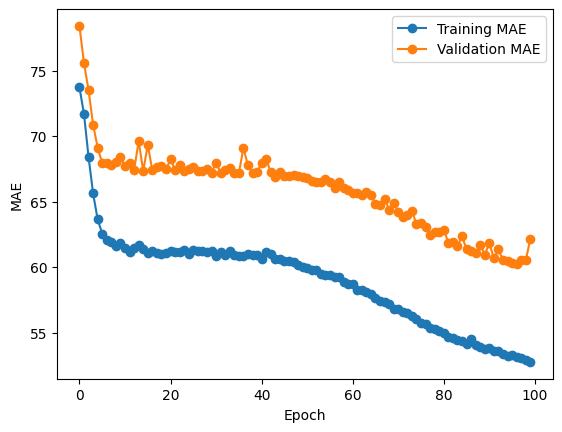

In [37]:
print(history.history.keys())
plt.plot(history.history['mae'], label='Training MAE', marker='o')
plt.plot(history.history['val_mae'], label='Validation MAE', marker='o')
plt.xlabel('Epoch')
plt.legend()
plt.ylabel('MAE')
plt.show()

In [38]:
ethanol = features_from_formula("C2H5OH")
ethanol = tf.convert_to_tensor(ethanol)
ethanol = tf.reshape(ethanol, [1, N_INPUTS])
model.predict([ethanol])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_10
Received: inputs=('Tensor(shape=(1, 11))',)
  warnings.warn(msg)


array([[-78.271]], dtype=float32)